In [3]:
import re
from os.path import dirname, join

import keras.backend as keras_backend
from keras.layers import Conv1D, Lambda, Add
import numpy as np
import matplotlib.pylab as plt

from traits.api import Enum, HasStrictTraits, Int, Instance, List, Tuple

from blusky.transforms.apply_father_wavelet_1d import ApplyFatherWavlet1D
from blusky.transforms.cascade_tree import CascadeTree
from blusky.transforms.cascade_1d import Cascade1D
import blusky.datasets as datasets
from blusky.transforms.default_decimation import (NoDecimation, 
                                                  DefaultDecimation)
from blusky.transforms.i_decimation_method import IDecimationMethod
from blusky.wavelets.i_wavelet_1d import IWavelet1D
from blusky.utils.pad_1d import pad_to_log2, Pad1D


In [4]:
base_directory = join(dirname(datasets.__file__), "scatnet")

In [5]:
from blusky.wavelets.wavelet_factories_1d import (vanilla_gabor_1d, 
                                                  vanilla_morlet_1d,
                                                  calibrate_wavelets_1d)
from keras.layers import Input
from keras import Model

N = 133
order = 3
sample_rate = 0.001
# arbitrary rate of oversampling
oversampling = 3
conv_padding = "valid"
J = 5

wavelets = [vanilla_morlet_1d(sample_rate, J, j=i) 
                    for i in range(0,J)]
calibrate_wavelets_1d(wavelets)

father_wavelet = vanilla_gabor_1d(sample_rate, J)

deci = DefaultDecimation(oversampling=oversampling)
inp = Input(shape=(N,1))

# pad
pad_1d = Pad1D(wavelets, decimation=deci, conv_padding=conv_padding)
padded = pad_1d.pad(inp)

#
cascade_tree = CascadeTree(padded, order=order)

cascade = Cascade1D(decimation=deci, _padding=conv_padding)
convs = cascade.transform(cascade_tree, wavelets=wavelets)

# Create layers to remove padding
cascade_tree = CascadeTree(padded, order=order)
cascade_tree.generate(wavelets, pad_1d.unpad)
unpad = cascade_tree.get_convolutions()

# Remove the padding
unpadded_convs = [i[1](i[0]) for i in zip(convs, unpad)]

ts = np.genfromtxt(join(base_directory, 'timeseries.csv'),
        delimiter=',', skip_header=1)

model = Model(inputs=inp, outputs=unpadded_convs)
#model.summary()

data = np.zeros((1,N,1))
data[0,:,0] = ts[:N,1]

result = model.predict(data)



Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


/home/brendon/Projects/blusky/blusky/blusky/wavelets/wavelet_factories_1d.py:46: RuntimeWarning: invalid value encountered in double_scalars
  step = np.pi * 2**(-J/Q) * (1-1/4*sigma0/_sigma_phi*2**(1./Q))/P


In [6]:
ts.shape

(252, 7)

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 133, 1)       0                                            
__________________________________________________________________________________________________
reflection_padding1d_32 (Reflec (None, 261, 1)       0           input_2[0][0]                    
__________________________________________________________________________________________________
reflection_padding1d_33 (Reflec (None, 268, 1)       0           reflection_padding1d_32[0][0]    
__________________________________________________________________________________________________
reflection_padding1d_34 (Reflec (None, 276, 1)       0           reflection_padding1d_32[0][0]    
__________________________________________________________________________________________________
reflection

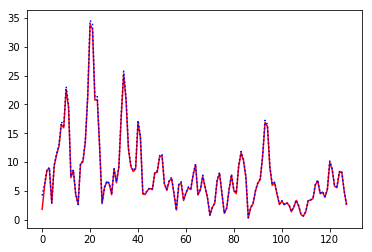

In [10]:
x_psi_real = np.genfromtxt(join(base_directory, 'x_psi_real-p1-j0.csv'),
                     delimiter=',')
x_psi_imag = np.genfromtxt(join(base_directory, 'x_psi_imag-p1-j0.csv'),
                     delimiter=',')

x_psi = x_psi_real + x_psi_imag*1j

plt.figure()
#plt.plot(np.pad(np.abs(x_psi),45,mode='constant', constant_values=0),'-r')
plt.plot(np.abs(x_psi),'-r')
plt.plot(result[0][0,:,0],":b")
plt.show()

/Users/blasscock/Documents/Code/sandia-blusky/blusky/wavelets/wavelet_factories_1d.py:46: RuntimeWarning: invalid value encountered in double_scalars
  step = np.pi * 2**(-J/Q) * (1-1/4*sigma0/_sigma_phi*2**(1./Q))/P


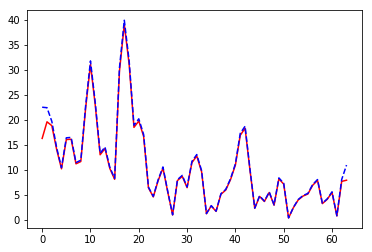

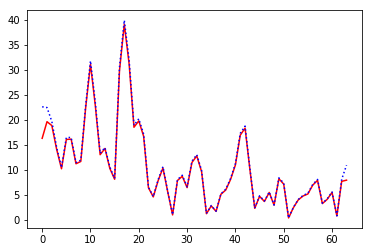

In [22]:
x_psi_real = np.genfromtxt(join(base_directory, 'x_psi_real-p2-j0.csv'),
                     delimiter=',')
x_psi_imag = np.genfromtxt(join(base_directory, 'x_psi_imag-p2-j0.csv'),
                     delimiter=',')

x_psi = x_psi_real + x_psi_imag*1j

ts = np.genfromtxt(join(base_directory, 'timeseries.csv'),
                   delimiter=',', skip_header=1)

wav = vanilla_morlet_1d(0.001, 5, 1)
x = wav.kernel(128*2)

_xm = np.pad(ts[:128,1], 64, mode='reflect')
yp = np.convolve(x,_xm,mode='same')

plt.figure()
plt.plot(np.abs(x_psi),'-r')
plt.plot(np.abs(yp[65:-63:2]),'--b')
plt.show()


plt.figure()
plt.plot(np.abs(x_psi),'-r')
plt.plot(result[1][0,::2,0],":b")
plt.show()

/Users/blasscock/Documents/Code/sandia-blusky/blusky/wavelets/wavelet_factories_1d.py:46: RuntimeWarning: invalid value encountered in double_scalars
  step = np.pi * 2**(-J/Q) * (1-1/4*sigma0/_sigma_phi*2**(1./Q))/P


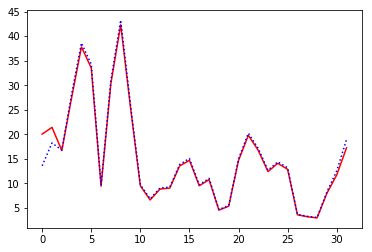

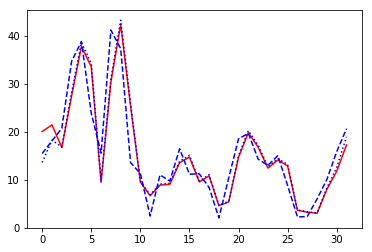

In [28]:
x_psi_real = np.genfromtxt(join(base_directory, 'x_psi_real-p3-j0.csv'),
                     delimiter=',')
x_psi_imag = np.genfromtxt(join(base_directory, 'x_psi_imag-p3-j0.csv'),
                     delimiter=',')

x_psi = x_psi_real + x_psi_imag*1j

ts = np.genfromtxt(join(base_directory, 'timeseries.csv'),
        delimiter=',', skip_header=1)

wav = vanilla_morlet_1d(0.001, 5, 2)
x = wav.kernel(128*2)

_xm = np.pad(ts[:128,1], 64, mode='reflect')
yp = np.convolve(x,_xm,mode='same')

plt.figure()
plt.plot(np.abs(x_psi),'-r')
plt.plot(result[2][0,::4,0],":b")
plt.show()

#The "same padding" introduces a phase shift in the decimated result#
plt.figure()
plt.plot(np.abs(x_psi),'-r')
plt.plot(result[2][0,::4,0],":b")
plt.plot(np.abs(yp[67:-64:4]),'--b')
plt.show()



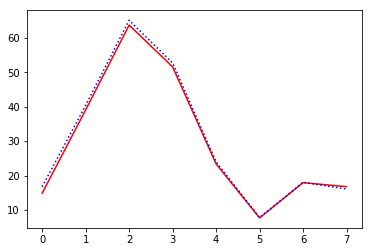

In [29]:
x_psi_real = np.genfromtxt(join(base_directory, 'x_psi_real-p5-j0.csv'),
                     delimiter=',')
x_psi_imag = np.genfromtxt(join(base_directory, 'x_psi_imag-p5-j0.csv'),
                     delimiter=',')

x_psi = x_psi_real + x_psi_imag*1j

ts = np.genfromtxt(join(base_directory, 'timeseries.csv'),
        delimiter=',', skip_header=1)

plt.figure()
plt.plot(np.abs(x_psi),'-r')
plt.plot(result[4][0,::4,0]/4.,":b")
plt.show()



0 (1, 128, 1)


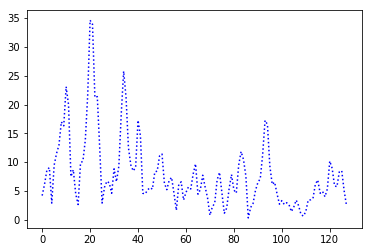

1 (1, 128, 1)


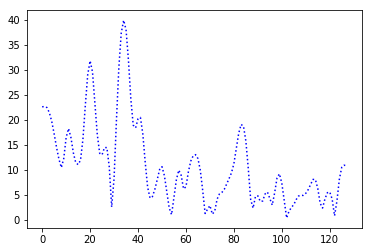

2 (1, 128, 1)


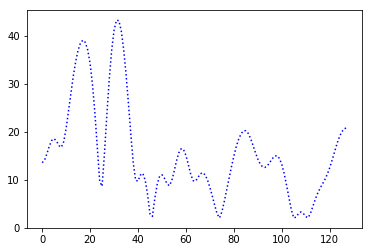

3 (1, 64, 1)


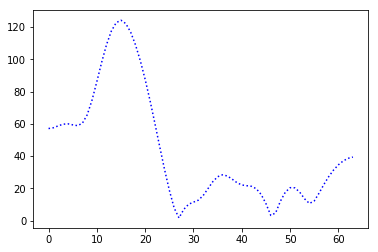

4 (1, 32, 1)


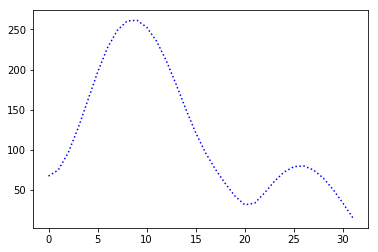

5 (1, 128, 1)


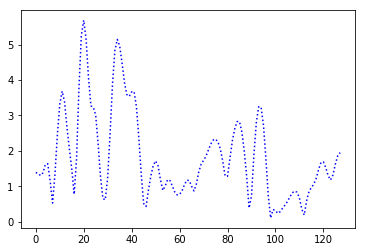

6 (1, 128, 1)


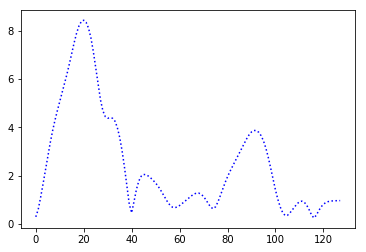

7 (1, 64, 1)


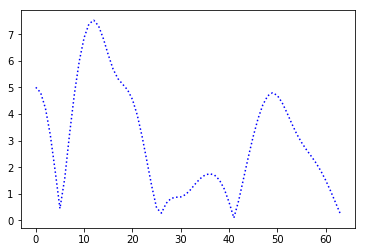

8 (1, 32, 1)


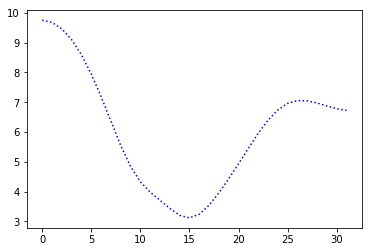

9 (1, 128, 1)


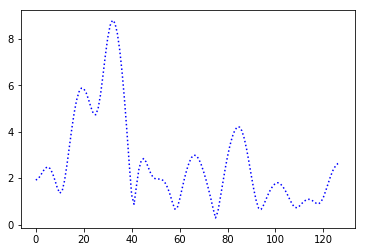

10 (1, 64, 1)


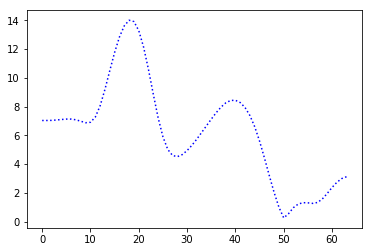

11 (1, 32, 1)


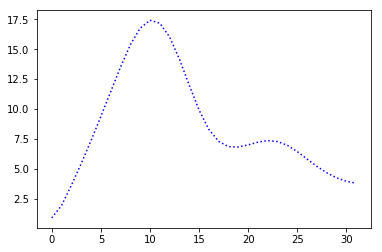

12 (1, 64, 1)


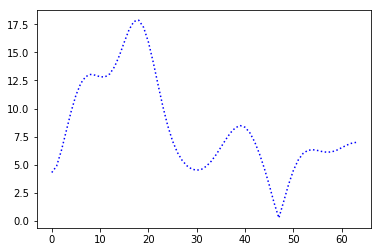

13 (1, 32, 1)


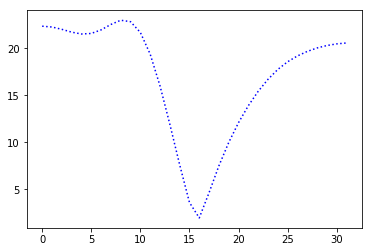

14 (1, 32, 1)


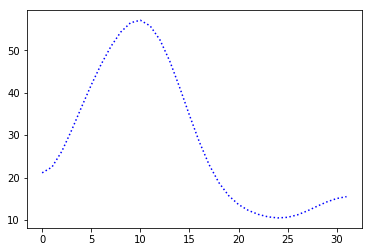

15 (1, 128, 1)


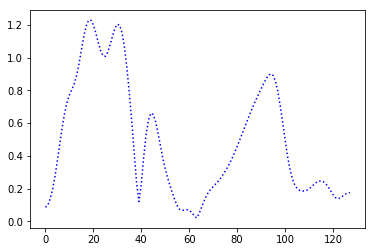

16 (1, 64, 1)


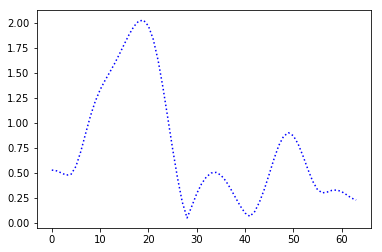

17 (1, 32, 1)


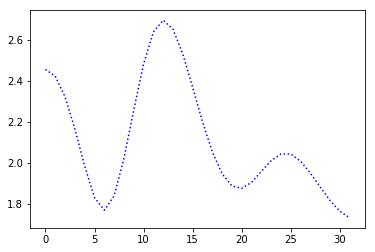

18 (1, 64, 1)


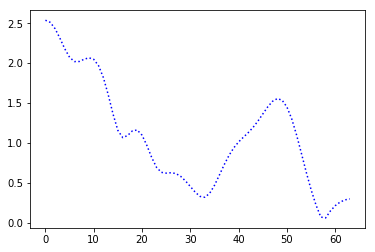

19 (1, 32, 1)


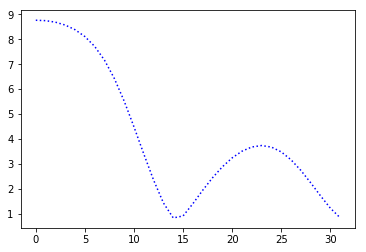

20 (1, 32, 1)


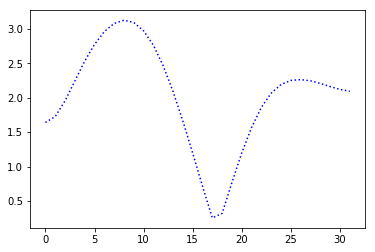

21 (1, 64, 1)


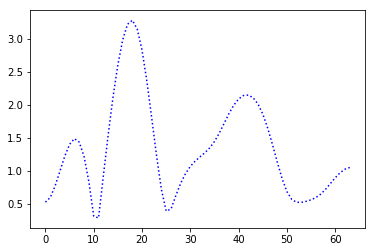

22 (1, 32, 1)


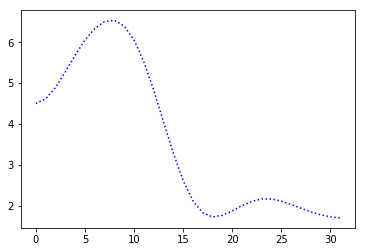

23 (1, 32, 1)


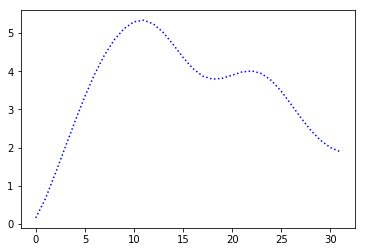

24 (1, 32, 1)


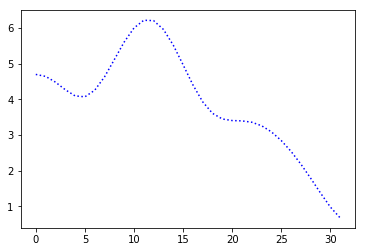

In [30]:
for i,res in enumerate(result):
    print (i,res.shape)
    plt.figure()
    plt.plot(res[0,:,0],":b")
    plt.show()

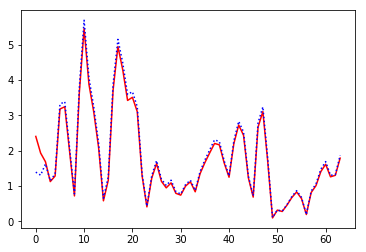

In [33]:

x_psi_real = np.genfromtxt(join(base_directory, 'x_psi_real-psi1psi2.csv'),
                     delimiter=',')

x_psi_imag = np.genfromtxt(join(base_directory, 'x_psi_imag-psi1psi2.csv'),
                     delimiter=',')

x_psi = x_psi_real + x_psi_imag*1j

ts = np.genfromtxt(join(base_directory, 'timeseries.csv'),
        delimiter=',', skip_header=1)

# psi2/psi3
plt.figure()
plt.plot(np.abs(x_psi),'-r')
plt.plot(result[5][0,::2,0],":b")

plt.show()

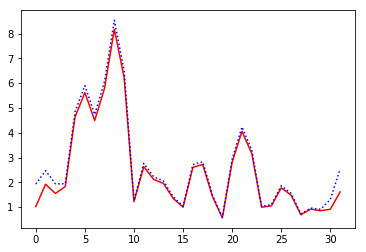

In [30]:
x_psi_real = np.genfromtxt(join(base_directory, 'x_psi_real-psi2psi3.csv'),
                     delimiter=',')

x_psi_imag = np.genfromtxt(join(base_directory, 'x_psi_imag-psi2psi3.csv'),
                     delimiter=',')

x_psi = x_psi_real + x_psi_imag*1j

plt.figure()
plt.plot(np.abs(x_psi),'-r')
plt.plot(result[9][0,:,0]/32.,":b")
plt.show()

In [34]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 1)       0                                            
__________________________________________________________________________________________________
reflection_padding1d_63 (Reflec (None, 256, 1)       0           input_3[0][0]                    
__________________________________________________________________________________________________
reflection_padding1d_64 (Reflec (None, 263, 1)       0           reflection_padding1d_63[0][0]    
__________________________________________________________________________________________________
reflection_padding1d_65 (Reflec (None, 271, 1)       0           reflection_padding1d_63[0][0]    
__________________________________________________________________________________________________
reflection